In [99]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,roc_auc_score,accuracy_score,RocCurveDisplay
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay


In [100]:
inflation_df = pd.read_csv("potentialDataSetsHW2/us_inflation.csv")
interest_df = pd.read_csv("potentialDataSetsHW2/us_interest_rates.csv")
gdp_df = pd.read_csv("potentialDataSetsHW2/usa_gdp.csv")

inflation_df = inflation_df.dropna()
# have an "ave" (average) row per year with NaN values, so we dropped it
interest_df = interest_df.dropna()
gdp_df = gdp_df.iloc[:,1:].dropna()

gdp_df.head()
gdp_df = gdp_df.rename(columns={"date":"year"})

In [101]:
gdp_df.head()

,year,gdp,gdp_cap
0,1960,5.419886e+11,2999.864872
1,1961,5.619403e+11,3059.160821
2,1962,6.036394e+11,3236.013112
3,1963,6.370586e+11,3366.369790
4,1964,6.841446e+11,3565.314430


In [102]:
inflation_df['month_num'] = inflation_df['month_num'].astype(int)
inflation_df['date'] = inflation_df['year'].astype(str) + inflation_df['month_num'].apply(lambda x: f'{x:02d}')
inflation_df['date'] = inflation_df['date'].astype(str)
inflation_df.head()

,year,months,month_num,inflat_rate,date
0,1914,Jan,1,2.0,191401
1,1914,Feb,2,1.0,191402
2,1914,Mar,3,1.0,191403
3,1914,Apr,4,0.0,191404
4,1914,May,5,2.1,191405


In [103]:
interest_df['observation_date'] = pd.to_datetime(interest_df['observation_date'])
interest_df['date'] = interest_df['observation_date'].dt.strftime('%Y%m').astype(str)
interest_df.head()

,observation_date,months,month_num,interest_rate,date
0,1954-07-01 00:00:00+00:00,Jul,7,0.80,195407
1,1954-08-01 00:00:00+00:00,Aug,8,1.22,195408
2,1954-09-01 00:00:00+00:00,Sep,9,1.07,195409
3,1954-10-01 00:00:00+00:00,Oct,10,0.85,195410
4,1954-11-01 00:00:00+00:00,Nov,11,0.83,195411


In [104]:
credit_df = pd.read_excel("potentialDataSetsHW2/sce_credit.xlsx", sheet_name="Data")
reduced_credit_df = credit_df[["userid", "date", "weight", 
                               "N1_1", "N1_2", "N1_3", 
                               "N1_4","N1_5","N1_6",
                               "N2_1","N2_2", "N2_3",
                               "N2_4", "N2_5", "N2_6",
                               "N3", "N4_4", "N4_5", "N4_6",
                               "N10_1", "N10_2", "N10_3",
                               "N10_4", "N10_5", "N10_7",
                               "N15", "N16",
                               "N22", "N23", "N25"]]
reduced_credit_df


KeyboardInterrupt: 

In [ ]:
reduced_credit_df['date'] = reduced_credit_df['date'].astype(str)
gdp_df['year'] = gdp_df['year'].astype(str)
reduced_credit_df['year'] = reduced_credit_df['date'].astype(str).str[:4]

C:\Users\izzyd\AppData\Local\Temp\ipykernel_22604\1854363984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_credit_df['date'] = reduced_credit_df['date'].astype(str)
C:\Users\izzyd\AppData\Local\Temp\ipykernel_22604\1854363984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_credit_df['year'] = reduced_credit_df['date'].astype(str).str[:4]


In [ ]:
reduced_credit_df.dtypes

userid      int64
date       object
weight    float64
N1_1        int64
N1_2        int64
N1_3        int64
N1_4        int64
N1_5        int64
N1_6        int64
N2_1      float64
N2_2      float64
N2_3      float64
N2_4      float64
N2_5      float64
N2_6      float64
N3        float64
N4_4      float64
N4_5      float64
N4_6      float64
N10_1     float64
N10_2     float64
N10_3     float64
N10_4     float64
N10_5     float64
N10_7     float64
N15       float64
N16       float64
N22       float64
N23       float64
N25       float64
year       object
dtype: object

In [ ]:
df_merged = reduced_credit_df.merge(inflation_df[['date', 'inflat_rate']], on='date', how='left')
df_merged = df_merged.merge(interest_df[['date', 'interest_rate']], on='date', how='left')
df_final = df_merged.merge(gdp_df, on='year', how='left')
df_final.head()

,userid,date,weight,N1_1,N1_2,N1_3,N1_4,N1_5,N1_6,N2_1,...,N15,N16,N22,N23,N25,year,inflat_rate,interest_rate,gdp,gdp_cap
0,70000337,201310,5.382,0,0,1,0,0,0,NaN,...,1.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
1,70000341,201310,0.557,1,1,1,0,1,0,20000.0,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
2,70003202,201310,0.868,0,1,0,0,0,0,NaN,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
3,70003205,201310,0.422,1,1,0,0,0,0,70000.0,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
4,70003238,201310,0.638,0,1,0,0,0,0,NaN,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777


In [ ]:
# if don't own a type of loan, their balance would be NaN, filling in with 0
df_final.loc[df_final['N1_1'] == 0, 'N2_1'] = 0
df_final.loc[df_final['N1_2'] == 0, 'N2_2'] = 0
df_final.loc[df_final['N1_3'] == 0, 'N2_3'] = 0
df_final.loc[df_final['N1_4'] == 0, 'N2_4'] = 0
df_final.loc[df_final['N1_5'] == 0, 'N2_5'] = 0
df_final.loc[df_final['N1_6'] == 0, 'N2_6'] = 0
# if not late by 30 days then not 90 days late
df_final.loc[df_final['N15'] == 0, 'N16'] = 0

May need to omit amount lended by loaner and request to increase loan

In [ ]:
df_final = df_final.drop(columns=["N4_4", "N4_5", "N4_6",
                               "N10_1", "N10_2", "N10_3",
                               "N10_4", "N10_5", "N10_7"])
df_final.isna().sum()

userid              0
date                0
weight              2
N1_1                0
N1_2                0
N1_3                0
N1_4                0
N1_5                0
N1_6                0
N2_1              910
N2_2              632
N2_3              269
N2_4              110
N2_5              503
N2_6              171
N3               8667
N15              3099
N16              3200
N22              1449
N23              2495
N25              7026
year                0
inflat_rate         0
interest_rate       0
gdp               980
gdp_cap           980
dtype: int64

In [ ]:
print (f"""Shape before cleaning {df_final.shape}""")
df_final_cleaned = df_final.dropna()
print (f"""Shape after cleaning {df_final_cleaned.shape}""")

Shape before cleaning (34362, 26)
Shape after cleaning (18797, 26)


In [ ]:
df_final_cleaned["date"].unique()

array(['201510', '201602', '201606', '201610', '201702', '201706',
       '201710', '201802', '201806', '201810', '201902', '201906',
       '201910', '202006', '202010', '202102', '202106', '202110',
       '202202', '202210', '202302', '202306', '202310'], dtype=object)

In [ ]:
df_final_cleaned.rename(columns={"N1_1":"HaveCredit", "N1_2":"HaveMortgage",
                                 "N1_3":"HaveStudent", "N1_4":"HaveHomeBasedLoan",
                                 "N1_5":"HaveAuto", "N1_6":"Other", "N1_7":"None",
                                 "N2_1":"CreditBal", "N2_2":"MortgageBal",
                                 "N2_3":"StudentBal", "N2_4":"HomeBasedBal",
                                 "N2_5":"AutoBal", "N2_6":"OtherBal",
                                 "N3":"MaxedCredit",
                                 "N15":"Late30Days", "N16":"Late90Days",
                                 "N22":"CreditScore", "N23":"LastCheckCredit",
                                 "N25":"LikAble2k"}, inplace=True)

C:\Users\izzyd\AppData\Local\Temp\ipykernel_22604\2633406663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned.rename(columns={"N1_1":"HaveCredit", "N1_2":"HaveMortgage",


In [ ]:
df_final_cleaned.head()

,userid,date,weight,HaveCredit,HaveMortgage,HaveStudent,HaveHomeBasedLoan,HaveAuto,Other,CreditBal,...,Late30Days,Late90Days,CreditScore,LastCheckCredit,LikAble2k,year,inflat_rate,interest_rate,gdp,gdp_cap
7004,70051996,201510,1.048,1,0,0,0,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7005,70052003,201510,0.491,1,1,1,0,1,0,2000.0,...,0.0,0.0,5.0,4.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7006,70052014,201510,0.577,1,0,0,1,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7008,70052043,201510,1.087,1,0,1,0,1,0,311.0,...,0.0,0.0,1.0,3.0,10.0,2015,0.2,0.12,1.829502e+13,57040.208214
7010,70052292,201510,0.784,1,1,0,0,0,0,1500.0,...,0.0,0.0,5.0,1.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214


Text(0.5, 1.0, 'Interest Rate')

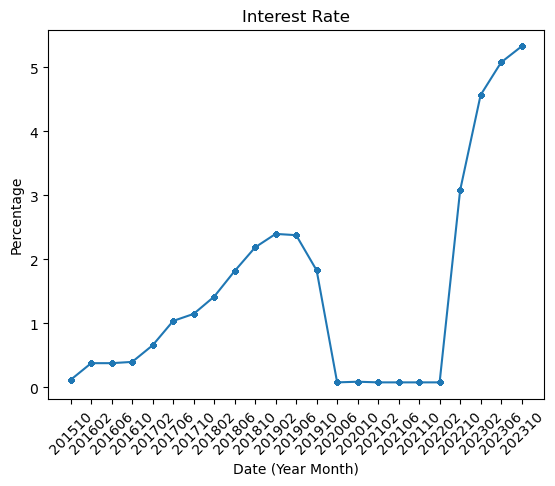

In [ ]:
plt.plot(df_final_cleaned["date"], df_final_cleaned["interest_rate"], ".-")
plt.xticks(rotation=45)
plt.xlabel("Date (Year Month)")
plt.ylabel("Percentage")
plt.title("Interest Rate")

Text(0.5, 1.0, 'Inflation Rate')

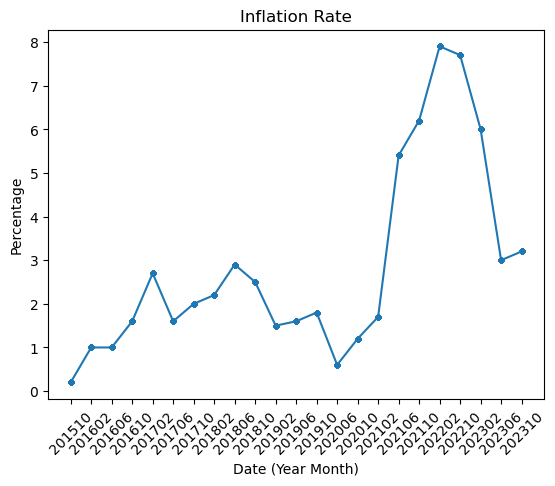

In [ ]:
plt.plot(df_final_cleaned["date"], df_final_cleaned["inflat_rate"], ".-")
plt.xticks(rotation=45)
plt.xlabel("Date (Year Month)")
plt.ylabel("Percentage")
plt.title("Inflation Rate")

In [ ]:
groupbydate = df_final_cleaned.groupby("date")["Late90Days"].count()
groupbydate.name = "CntLatePayment"
groupbydate = groupbydate.reset_index()

Text(0.5, 1.0, 'Late Payments Over Time')

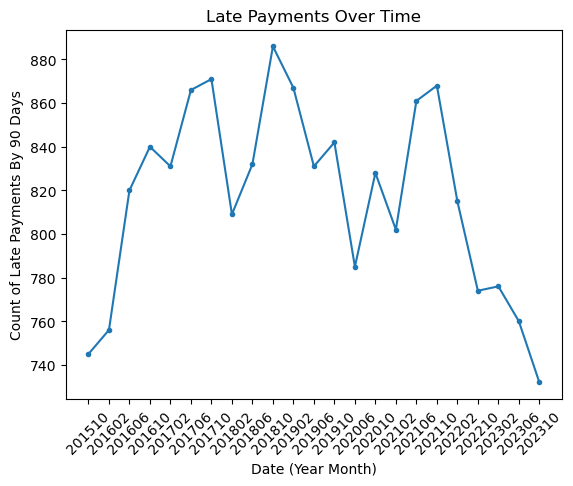

In [ ]:
plt.plot(groupbydate["date"], groupbydate["CntLatePayment"], ".-")
plt.xticks(rotation=45)
plt.xlabel("Date (Year Month)")
plt.ylabel("Count of Late Payments By 90 Days")
plt.title("Late Payments Over Time")

C:\Users\izzyd\AppData\Local\Temp\ipykernel_22604\4054372187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned["loan_count"] = (df_final_cleaned["HaveCredit"] + df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] +


Text(0, 0.5, 'Frequency')

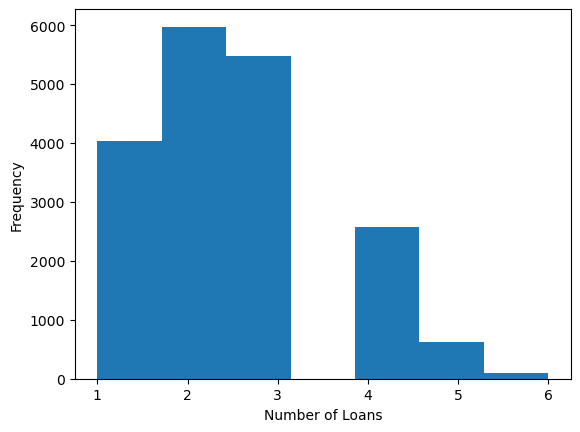

In [ ]:
df_final_cleaned["loan_count"] = (df_final_cleaned["HaveCredit"] + df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] + 
                          df_final_cleaned["HaveHomeBasedLoan"] + df_final_cleaned["HaveAuto"] + df_final_cleaned["Other"])

plt.hist(df_final_cleaned["loan_count"], bins = 7);
plt.xlabel("Number of Loans")
plt.ylabel("Frequency")

In [ ]:
df_final_cleaned["Late90Days"].value_counts()

Late90Days
0.0    18301
1.0      496
Name: count, dtype: int64

In [ ]:
df_final_cleaned["loan_count(w/outCredit)"] = (df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] + 
                          df_final_cleaned["HaveHomeBasedLoan"] + df_final_cleaned["HaveAuto"] + df_final_cleaned["Other"])

C:\Users\izzyd\AppData\Local\Temp\ipykernel_22604\1916653963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned["loan_count(w/outCredit)"] = (df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] +


In [ ]:
df_final_cleaned["loan_count"].describe()

count    18797.000000
mean         2.473373
std          1.103495
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: loan_count, dtype: float64

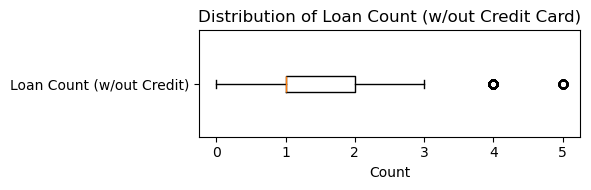

In [ ]:
plt.figure(figsize=(6, 2))
plt.boxplot(df_final_cleaned["loan_count(w/outCredit)"], vert=False)
plt.yticks([1], ["Loan Count (w/out Credit)"])
plt.xlabel("Count")
plt.title("Distribution of Loan Count (w/out Credit Card)")
plt.tight_layout()


In [ ]:
high_num_loans = df_final_cleaned[(df_final_cleaned["loan_count"]>=
                                   df_final_cleaned["loan_count"].quantile(0.8))]
high_num_loans["Late30Days"].value_counts()

Late30Days
0.0    8103
1.0     688
Name: count, dtype: int64

In [ ]:
high_num_loans["Late90Days"].value_counts()

Late90Days
0.0    8506
1.0     285
Name: count, dtype: int64

In [ ]:
low_num_loans = df_final_cleaned[(df_final_cleaned["loan_count"]<=df_final_cleaned["loan_count"].quantile(0.2))]
low_num_loans["Late30Days"].value_counts()

Late30Days
0.0    3929
1.0     104
Name: count, dtype: int64

In [ ]:
low_num_loans["Late90Days"].value_counts()

Late90Days
0.0    3983
1.0      50
Name: count, dtype: int64

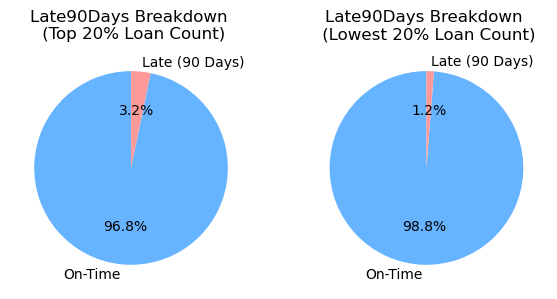

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
high_num_loans["Late90Days"].value_counts().sort_index().plot(
    kind='pie',
    labels=["On-Time", "Late (90 Days)"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66b3ff", "#ff9999"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Late90Days Breakdown \n (Top 20% Loan Count)")

# Low loan count pie chart
low_num_loans["Late90Days"].value_counts().sort_index().plot(
    kind='pie',
    labels=["On-Time", "Late (90 Days)"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66b3ff", "#ff9999"],
    ax=axes[1]
)
axes[1].set_ylabel("")
axes[1].set_title("Late90Days Breakdown \n (Lowest 20% Loan Count)")

plt.tight_layout()
plt.show()

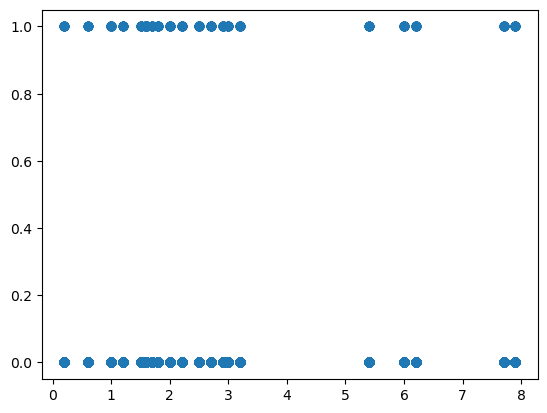

In [ ]:
plt.scatter(df_final_cleaned["inflat_rate"], df_final_cleaned["Late90Days"])

In [ ]:
table_normalized = pd.crosstab(
    df_final_cleaned["date"],
    df_final_cleaned["Late90Days"],
    normalize='index'  # This gives row-wise (date-wise) percentages
)
table_normalized

Late90Days,0.0,1.0
date,,
201510,0.974497,0.025503
201602,0.970899,0.029101
201606,0.979268,0.020732
201610,0.966667,0.033333
201702,0.971119,0.028881
201706,0.967667,0.032333
201710,0.974742,0.025258
201802,0.970334,0.029666
201806,0.963942,0.036058


C:\Users\izzyd\AppData\Local\Temp\ipykernel_22604\2837294837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned["TotalBal"] = (df_final_cleaned["CreditBal"] + df_final_cleaned["MortgageBal"] + df_final_cleaned["StudentBal"] +


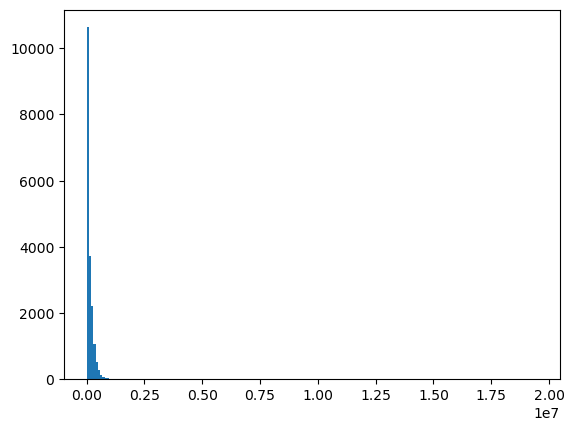

In [ ]:
df_final_cleaned["TotalBal"] = (df_final_cleaned["CreditBal"] + df_final_cleaned["MortgageBal"] + df_final_cleaned["StudentBal"] + 
                          df_final_cleaned["HomeBasedBal"] + df_final_cleaned["AutoBal"] + df_final_cleaned["OtherBal"])
plt.hist(df_final_cleaned["TotalBal"], bins = 200);
plt.show()

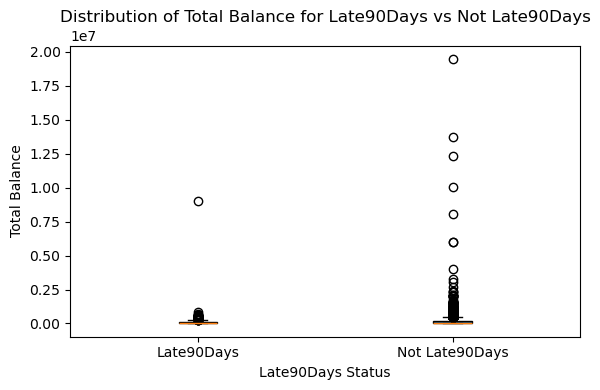

In [ ]:
late = df_final_cleaned[df_final_cleaned["Late90Days"] == True]
not_late = df_final_cleaned[df_final_cleaned["Late90Days"] == False]
plt.figure(figsize=(6, 4))

plt.boxplot([late["TotalBal"], not_late["TotalBal"]], vert=True, patch_artist=True)
plt.xticks([1, 2], ["Late90Days", "Not Late90Days"])

plt.ylabel("Total Balance")
plt.xlabel("Late90Days Status")
plt.title("Distribution of Total Balance for Late90Days vs Not Late90Days")

plt.tight_layout()
plt.show()

c:\Users\izzyd\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


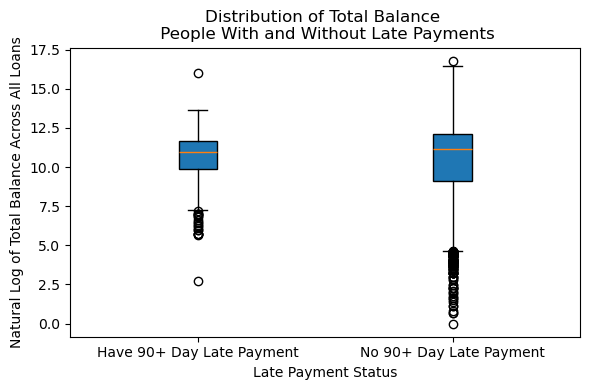

In [ ]:
late = df_final_cleaned[df_final_cleaned["Late90Days"] == True]
not_late = df_final_cleaned[df_final_cleaned["Late90Days"] == False]
plt.figure(figsize=(6, 4))

plt.boxplot([np.log(late["TotalBal"]), np.log(not_late["TotalBal"])], vert=True, patch_artist=True)
plt.xticks([1, 2], ["Have 90+ Day Late Payment", "No 90+ Day Late Payment"])

plt.ylabel("Natural Log of Total Balance Across All Loans")
plt.xlabel("Late Payment Status")
plt.title("Distribution of Total Balance \n People With and Without Late Payments")

plt.tight_layout()
plt.show()

In [ ]:
df_final_cleaned[["CreditBal", "MortgageBal", 
                   "StudentBal", "HomeBasedBal", "AutoBal", "OtherBal",
                   "Late30Days", "Late90Days"]].corr()

,CreditBal,MortgageBal,StudentBal,HomeBasedBal,AutoBal,OtherBal,Late30Days,Late90Days
CreditBal,1.000000,0.111665,0.004408,0.019391,0.450523,0.025393,0.016354,0.009682
MortgageBal,0.111665,1.000000,0.064296,0.031566,0.139444,0.003831,-0.035410,-0.024075
StudentBal,0.004408,0.064296,1.000000,-0.004169,0.596848,0.002350,0.021859,0.018978
HomeBasedBal,0.019391,0.031566,-0.004169,1.000000,0.043090,-0.000250,-0.004321,-0.010626
AutoBal,0.450523,0.139444,0.596848,0.043090,1.000000,0.000258,0.017104,0.004353
OtherBal,0.025393,0.003831,0.002350,-0.000250,0.000258,1.000000,0.015415,0.000028
Late30Days,0.016354,-0.035410,0.021859,-0.004321,0.017104,0.015415,1.000000,0.650335
Late90Days,0.009682,-0.024075,0.018978,-0.010626,0.004353,0.000028,0.650335,1.000000


In [ ]:
credit_score = pd.get_dummies(df_final_cleaned["CreditScore"], 
                              prefix="CreditScore", 
                              drop_first=True)
last_checked = pd.get_dummies(df_final_cleaned["LastCheckCredit"], 
                              prefix="LastCheckCredit",
                              drop_first=True)
X_merged = pd.concat([df_final_cleaned, credit_score, last_checked], axis =1)
X_merged.columns

Index(['userid', 'date', 'weight', 'HaveCredit', 'HaveMortgage', 'HaveStudent',
       'HaveHomeBasedLoan', 'HaveAuto', 'Other', 'CreditBal', 'MortgageBal',
       'StudentBal', 'HomeBasedBal', 'AutoBal', 'OtherBal', 'MaxedCredit',
       'Late30Days', 'Late90Days', 'CreditScore', 'LastCheckCredit',
       'LikAble2k', 'year', 'inflat_rate', 'interest_rate', 'gdp', 'gdp_cap',
       'loan_count', 'loan_count(w/outCredit)', 'TotalBal', 'CreditScore_2.0',
       'CreditScore_3.0', 'CreditScore_4.0', 'CreditScore_5.0',
       'CreditScore_6.0', 'LastCheckCredit_2.0', 'LastCheckCredit_3.0',
       'LastCheckCredit_4.0', 'LastCheckCredit_5.0', 'LastCheckCredit_6.0'],
      dtype='object')

In [ ]:
X = sm.add_constant(df_final_cleaned.drop(columns=["Late90Days","CreditScore",
                                                   "LastCheckCredit","date","year",
                                                   "weight", "userid","HaveCredit",'HaveMortgage', 
                                                   'HaveStudent','HaveHomeBasedLoan', 
                                                   'CreditBal', 'HomeBasedBal', 
                                                   'AutoBal', 'OtherBal',
                                                   'HaveAuto', 'Other',
                                                   "loan_count(w/outCredit)"]))
y = df_final_cleaned["Late90Days"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

logistic = sm.Logit(y_train, X_train).fit()
logistic.summary()

         Current function value: 0.039579
         Iterations: 35


c:\Users\izzyd\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Late90Days   No. Observations:                13157
Model:                          Logit   Df Residuals:                    13145
Method:                           MLE   Df Model:                           11
Date:                Wed, 30 Apr 2025   Pseudo R-squ.:                  0.6753
Time:                        11:39:05   Log-Likelihood:                -520.74
converged:                      False   LL-Null:                       -1603.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -98.5639   3.77e+04     -0.003      0.998   -7.39e+04    7.37e+04
MortgageBal    5.744e-07   1.05e-06      0.548      0.583   -1.48e-06    2.63e-06
StudentBal     5.793e-06    2.2e-06      2.629      0.009    1.47e-06    1.01e-05
MaxedCredit      -0.0528      0.159     -0.332      0.740      -0.364       0.259
Late30Days       97.4224   3.77e+04      0.003      0.998   -7.37e+04    7.39e+04
LikAble2k        -0.0096      0.002     -4.161      0.000      -0.014      -0.005
inflat_rate       0.1226      0.061      2.007      0.045       0.003       0.242
interest_rate     0.0525      0.085      0.620      0.535      -0.113       0.218
gdp            -1.29e-12   1.21e-12     -1.065      0.287   -3.66e-12    1.08e-12
gdp_cap           0.0004      0.000      0.987      0.324      -0.000       0.001
loan_count       -0.1844      0.074     -2.502      0.012      -0.329      -0.040
TotalBal        -5.5e-07   9.14e-07     -0.602      0.547   -2.34e-06    1.24e-06
=================================================================================

Possibly complete quasi-separation: A fraction 0.94 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
X_test = sm.add_constant(X_test)
predictions_test = (logistic.predict(X_test) >= 0.5).astype(int)

In [ ]:
confusion_matrix(y_test, predictions_test)

array([[5420,   71],
       [  87,   62]])

In [ ]:
print(precision_score(y_test, predictions_test))
print (recall_score(y_test, predictions_test))

0.46616541353383456
0.4161073825503356


# Israel Test Part

In [ ]:
X = df_final_cleaned.drop(columns=["Late90Days","CreditScore",
                                                   "LastCheckCredit","date","year",
                                                   "weight", "userid","HaveCredit",'HaveMortgage', 
                                                   'HaveStudent','HaveHomeBasedLoan', 
                                                   'CreditBal', 'HomeBasedBal', 
                                                   'AutoBal', 'OtherBal',
                                                   'HaveAuto', 'Other',
                                                   "loan_count(w/outCredit)"])

Y = df_final_cleaned["Late90Days"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=y)
# Store the original column names before scaling
feature_names = X.columns.tolist()


In [ ]:

scaler=StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Convert scaled arrays back to DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [ ]:
cv=StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
# Define your model
model = LogisticRegression(random_state=42)


cv_results = cross_validate(model, X_train_scaled, y_train, cv=cv, 
                           scoring=['accuracy',"roc_auc"], return_train_score=True)

In [ ]:
# Extract and display CV results
print("Cross-Validation Results:")
print(f"CV Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f} ± {np.std(cv_results['test_accuracy']):.4f}")
print(f"CV Validation ROC AUC: {np.mean(cv_results['test_roc_auc']):.4f} ± {np.std(cv_results['test_roc_auc']):.4f}")

print(f"CV Test Accuracy: {np.mean(cv_results['train_accuracy']):.4f} ± {np.std(cv_results['train_accuracy']):.4f}")
print(f"CV Test ROC AUC: {np.mean(cv_results['train_roc_auc']):.4f} ± {np.std(cv_results['train_roc_auc']):.4f}")

Cross-Validation Results:
CV Validation Accuracy: 0.9752 ± 0.0032
CV Validation ROC AUC: 0.9860 ± 0.0018
CV Test Accuracy: 0.9757 ± 0.0003
CV Test ROC AUC: 0.9866 ± 0.0002


In [ ]:
final_model=model.fit(X_train_scaled,y_train)

In [ ]:
print("\nFeature Coeffiecent Analysis:")
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficent': final_model.coef_[0]
}).sort_values('Coefficent', ascending=False)
feature_importance


Feature Coeffiecent Analysis:


,Feature,Coefficent
3,Late30Days,2.282720
5,inflat_rate,0.246726
6,interest_rate,0.241867
0,MortgageBal,0.194002
1,StudentBal,0.192465
7,gdp,-0.075429
2,MaxedCredit,-0.077100
9,loan_count,-0.106517
8,gdp_cap,-0.107625
10,TotalBal,-0.188793


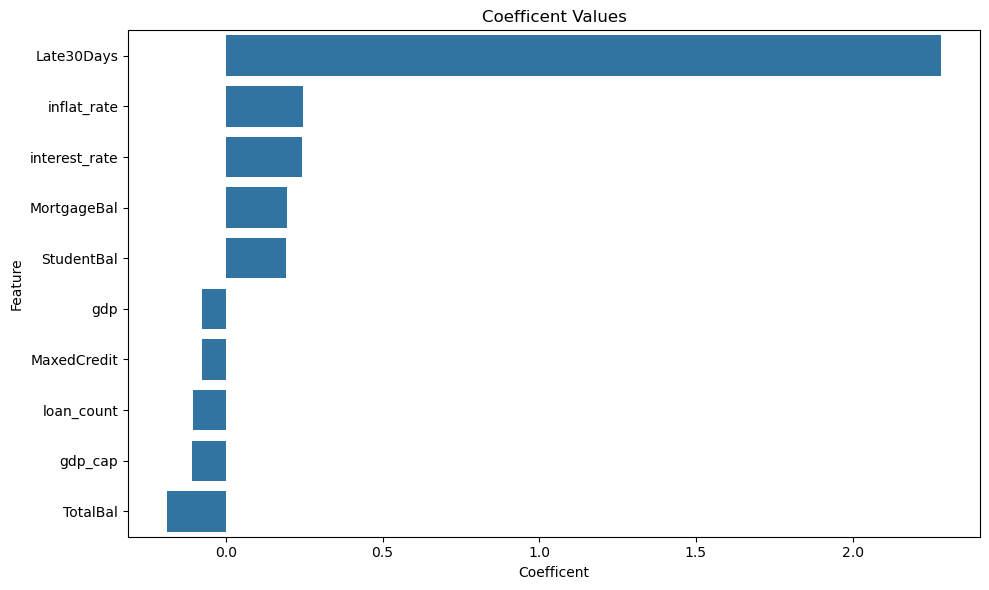

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficent', y='Feature', data=feature_importance.head(10))
plt.title('Coefficent Values')
plt.tight_layout()

In [ ]:
y_pred= final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

array([3.75285593e-05, 2.63762812e-05, 5.00665039e-05, ...,
       6.52779546e-05, 2.19763095e-05, 2.99482809e-05])

In [ ]:
# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")


Test Accuracy: 0.9770
Test ROC AUC: 0.9876


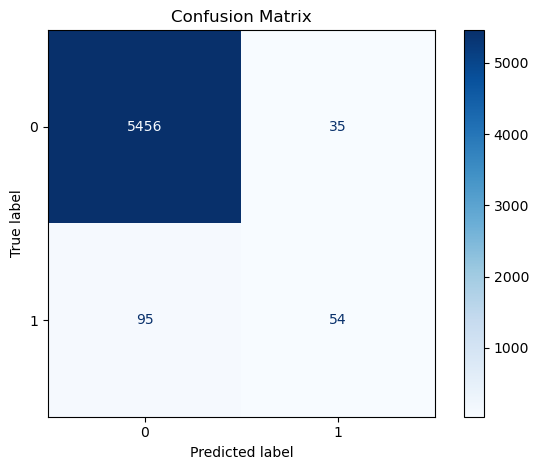

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()

Text(0.5, 1.0, 'Calibration Curve (Logistic Regression)')

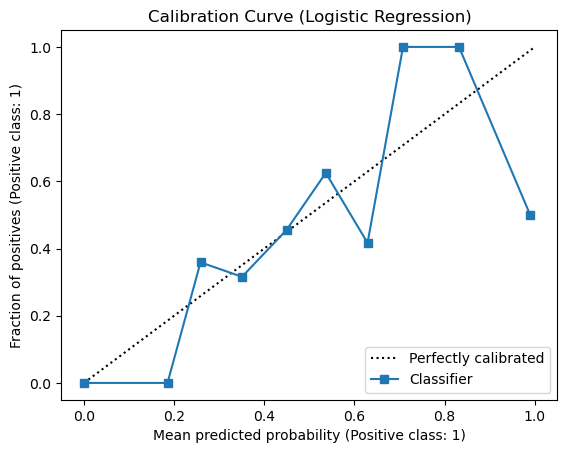

In [105]:
CalibrationDisplay.from_predictions(y_test, y_pred_proba, n_bins=10, strategy='uniform')
plt.title("Calibration Curve (Logistic Regression)")